In [2]:
# CÉLULA 1: CARREGAR, RECONSTRUIR E PREPARAR OS DADOS

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import requests
from datetime import datetime, timedelta

# --- PASSO 1: RECONSTRUIR O DATAFRAME DO NOTEBOOK 09 ---

# 1.1 Carregar os dados de fluxo de ordens que guardámos
print("A carregar dados de fluxo de ordens do ficheiro Parquet...")
trade_flow_path = 'user_data/data/binance/trades_agg_90d_BTCUSDT.parquet'
df_flow = pd.read_parquet(trade_flow_path)

# 1.2 Criar as features de engenharia (código do Notebook 09)
print("A recriar features de engenharia...")
# Features de 'buy_ratio'
df_flow['buy_ratio_sma_12'] = df_flow['buy_ratio'].rolling(window=12).mean()
df_flow['buy_ratio_ema_12'] = df_flow['buy_ratio'].ewm(span=12, adjust=False).mean()
df_flow['buy_ratio_sma_26'] = df_flow['buy_ratio'].rolling(window=26).mean()
df_flow['buy_ratio_ema_26'] = df_flow['buy_ratio'].ewm(span=26, adjust=False).mean()
rolling_mean = df_flow['buy_ratio'].rolling(window=50).mean()
rolling_std = df_flow['buy_ratio'].rolling(window=50).std()
df_flow['buy_ratio_zscore_50'] = (df_flow['buy_ratio'] - rolling_mean) / rolling_std
# Features de aceleração e dominância
df_flow['trade_count_accel'] = df_flow['trade_count'].pct_change()
df_flow['buy_volume_accel'] = df_flow['buy_volume'].pct_change()
df_flow['sell_volume_accel'] = df_flow['sell_volume'].pct_change()
total_volume = df_flow['buy_volume'] + df_flow['sell_volume']
df_flow['volume_dominance'] = (df_flow['buy_volume'] - df_flow['sell_volume']) / total_volume
df_flow.fillna(0, inplace=True)

# 1.3 Descarregar dados de velas (OHLCV) via API (código do Notebook 09)
print("A descarregar dados de velas (OHLCV) da API da Binance...")
# (Esta função é uma versão simplificada para ser mais rápida)
def get_klines_from_api(symbol="BTCUSDT", interval="15m", days=90):
    url = "https://api.binance.com/api/v3/klines"
    end_time = datetime.utcnow( )
    start_time = end_time - timedelta(days=days)
    all_klines = []
    while start_time < end_time:
        params = {'symbol': symbol, 'interval': interval, 'startTime': int(start_time.timestamp() * 1000), 'limit': 1000}
        klines = requests.get(url, params=params).json()
        if not klines: break
        all_klines.extend(klines)
        start_time = pd.to_datetime(klines[-1][0], unit='ms') + timedelta(milliseconds=1)
    df = pd.DataFrame(all_klines, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'ct', 'qav', 'not', 'tbbav', 'tbqav', 'ign'])
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
    for col in df.columns[1:]: df[col] = pd.to_numeric(df[col])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.set_index('date', inplace=True)
    return df

df_ohlcv = get_klines_from_api()

# 1.4 Juntar tudo e criar o alvo (código do Notebook 09)
print("A juntar datasets e a criar a variável alvo...")
df_final = pd.merge(df_flow, df_ohlcv, left_index=True, right_index=True, how='inner')
HORIZONTE = 5
LIMITE_LUCRO = 0.005
future_max_high = df_final['high'].shift(-HORIZONTE).rolling(window=HORIZONTE).max()
success_condition = (future_max_high > df_final['close'] * (1 + LIMITE_LUCRO))
df_final['target'] = np.where(success_condition, 1, 0)
df_final.dropna(inplace=True)
print("--- Reconstrução do 'df_final' concluída! ---")


# --- PASSO 2: PREPARAÇÃO PARA O MODELO (código original desta célula) ---

# 2.1 Seleção de Features e Alvo
y = df_final['target']
features_to_drop = ['target', 'open', 'high', 'low', 'close', 'volume']
X = df_final.drop(columns=features_to_drop)

print(f"\nDataset preparado com {X.shape[1]} features.")

# 2.2 Escalonamento das Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# 2.3 Divisão em Treino, Validação e Teste
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print("\nDivisão dos dados concluída (sem baralhar):")
print(f"  - Amostras de Treino:    {len(X_train)}")
print(f"  - Amostras de Validação: {len(X_val)}")
print(f"  - Amostras de Teste:      {len(X_test)}")


A carregar dados de fluxo de ordens do ficheiro Parquet...
A recriar features de engenharia...
A descarregar dados de velas (OHLCV) da API da Binance...


/var/folders/_h/bzklzp017rd0m7tqv52p2lym0000gn/T/ipykernel_14432/2777403117.py:40: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow( )


A juntar datasets e a criar a variável alvo...
--- Reconstrução do 'df_final' concluída! ---

Dataset preparado com 13 features.

Divisão dos dados concluída (sem baralhar):
  - Amostras de Treino:    6818
  - Amostras de Validação: 852
  - Amostras de Teste:      853


In [3]:
# CÉLULA 2: PREPARAR SEQUÊNCIAS, CONSTRUIR E TREINAR O MODELO LSTM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. Função para Criar Sequências ---
def create_sequences(X, y, time_steps=10):
    """
    Cria sequências de dados para a LSTM.
    Para cada ponto no tempo, pega os 'time_steps' anteriores como features.
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# --- Parâmetros da Sequência ---
TIME_STEPS = 12 # Vamos usar as últimas 12 velas (3 horas) para fazer uma previsão

# --- 2. Criar os Datasets de Sequências ---
print(f"A criar sequências com um histórico de {TIME_STEPS} velas...")
X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIME_STEPS)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, TIME_STEPS)

print("\nDimensões dos dados de sequência (amostras, timesteps, features):")
print(f"  - X_train_seq: {X_train_seq.shape}")
print(f"  - X_val_seq:   {X_val_seq.shape}")
print(f"  - X_test_seq:  {X_test_seq.shape}")


# --- 3. Construir o Modelo LSTM ---
print("\nA construir o modelo LSTM...")

# Limpa qualquer sessão anterior do Keras
tf.keras.backend.clear_session()

model = Sequential([
    # Camada LSTM de entrada. input_shape = (timesteps, número de features)
    LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2), # Dropout para combater overfitting
    
    # Segunda camada LSTM
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    # Camada Densa para processamento
    Dense(units=25, activation='relu'),
    
    # Camada de Saída. 'sigmoid' para classificação binária (0 ou 1)
    Dense(units=1, activation='sigmoid')
])

# --- 4. Compilar o Modelo ---
# Usamos 'binary_crossentropy' porque o nosso alvo é 0 ou 1.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


# --- 5. Treinar o Modelo ---
print("\nIniciando o treino do modelo...")

# Callbacks para otimizar o treino
# EarlyStopping: para o treino se a performance na validação não melhorar
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# ModelCheckpoint: guarda o melhor modelo encontrado durante o treino
model_checkpoint = ModelCheckpoint('oraculo_v2_best_model.h5', monitor='val_loss', save_best_only=True)

# Parâmetros de treino
EPOCHS = 100
BATCH_SIZE = 64

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\n--- Treino concluído! ---")
print("O melhor modelo foi guardado em 'oraculo_v2_best_model.h5'")


A criar sequências com um histórico de 12 velas...

Dimensões dos dados de sequência (amostras, timesteps, features):
  - X_train_seq: (6806, 12, 13)
  - X_val_seq:   (840, 12, 13)
  - X_test_seq:  (841, 12, 13)

A construir o modelo LSTM...


2025-09-20 21:13:37.130114: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-20 21:13:37.130156: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-20 21:13:37.130159: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-20 21:13:37.130327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-20 21:13:37.130337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When u

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,301 (133.99 KB)

 Trainable params: 34,301 (133.99 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treino do modelo...
Epoch 1/100


2025-09-20 21:13:38.129315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8418 - loss: 0.4569

107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8659 - loss: 0.3931 - val_accuracy: 0.8881 - val_loss: 0.3573
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8769 - loss: 0.3506 - val_accuracy: 0.8881 - val_loss: 0.3578
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8764 - loss: 0.3506 - val_accuracy: 0.8881 - val_loss: 0.3628
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8762 - loss: 0.3534

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8769 - loss: 0.3474 - val_accuracy: 0.8881 - val_loss: 0.3483
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8766 - loss: 0.3439 - val_accuracy: 0.8881 - val_loss: 0.3624
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8776 - loss: 0.3405 - val_accuracy: 0.8881 - val_loss: 0.3537
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8776 - loss: 0.3360 - val_accuracy: 0.8881 - val_loss: 0.3544
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8772 - loss: 0.3303 - val_accuracy: 0.8869 - val_loss: 0.3630
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8779 - loss: 0.3283 - val_accuracy: 0.8881 - val_loss: 0.3703
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8797 - loss: 0.3251 - val_accuracy: 0.8821 - val_loss: 0.3701
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8804 - loss: 0.3196 - val_accura

A carregar o melhor modelo guardado: 'oraculo_v2_best_model.h5'
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

--- Relatório de Classificação ---
                    precision    recall  f1-score   support

  Classe 0 (Falha)       0.91      1.00      0.95       768
Classe 1 (Sucesso)       0.00      0.00      0.00        73

          accuracy                           0.91       841
         macro avg       0.46      0.50      0.48       841
      weighted avg       0.83      0.91      0.87       841


--- Matriz de Confusão ---


/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

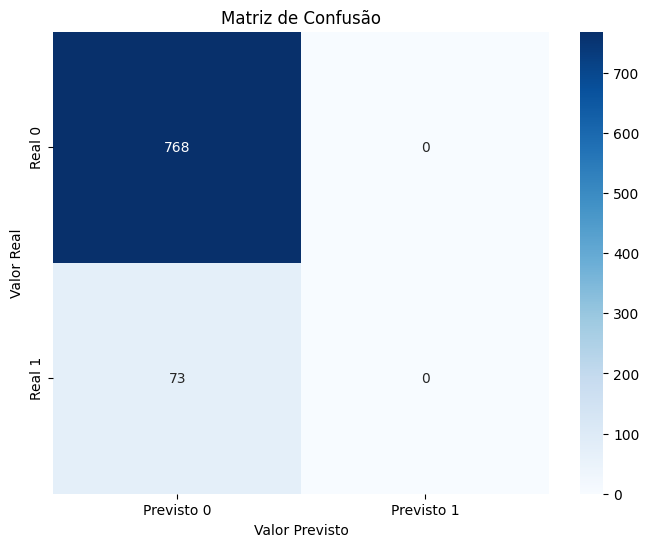


Área sob a Curva ROC (AUC): 0.5965


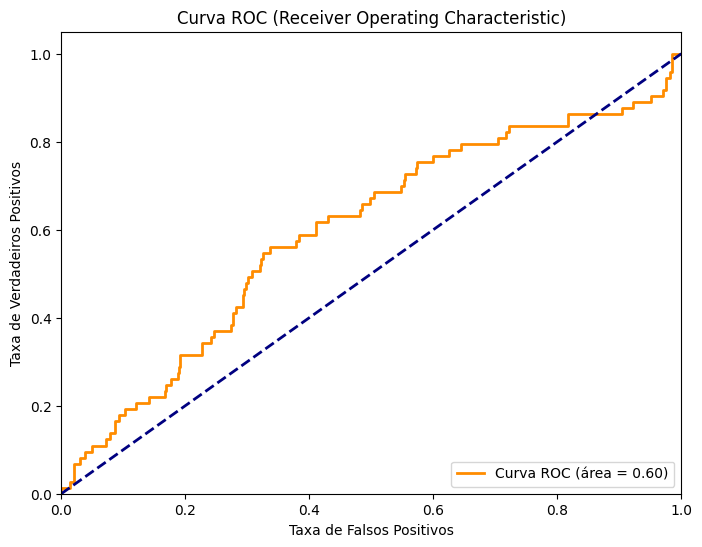

In [4]:
# CÉLULA 3: AVALIAÇÃO DA PERFORMANCE DO MODELO NO CONJUNTO DE TESTE

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model

# --- 1. Carregar o Melhor Modelo Guardado ---
print("A carregar o melhor modelo guardado: 'oraculo_v2_best_model.h5'")
best_model = load_model('oraculo_v2_best_model.h5')

# --- 2. Fazer Previsões no Conjunto de Teste ---
y_pred_proba = best_model.predict(X_test_seq)
# Converte as probabilidades para classes (0 ou 1) usando um limiar de 0.5
y_pred = (y_pred_proba > 0.5).astype(int)

# --- 3. Relatório de Classificação ---
print("\n--- Relatório de Classificação ---")
# Este relatório mostra a precisão, recall e f1-score para cada classe.
print(classification_report(y_test_seq, y_pred, target_names=['Classe 0 (Falha)', 'Classe 1 (Sucesso)']))

# --- 4. Matriz de Confusão ---
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Previsto 0', 'Previsto 1'], 
            yticklabels=['Real 0', 'Real 1'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# --- 5. Curva ROC ---
# Mede a capacidade do modelo de distinguir entre as classes.
# Quanto mais a curva se aproxima do canto superior esquerdo, melhor.
fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"\nÁrea sob a Curva ROC (AUC): {roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()


In [5]:
# CÉLULA 4: RE-TREINO DO MODELO COM PESOS DE CLASSE (CLASS WEIGHTS)

from sklearn.utils.class_weight import compute_class_weight

# --- 1. Calcular os Pesos das Classes ---
# Isto calcula pesos inversamente proporcionais à frequência das classes.
# A classe minoritária (1) receberá um peso muito maior.
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
# Transforma num dicionário que o Keras entende: {classe_0: peso_0, classe_1: peso_1}
class_weights_dict = dict(enumerate(class_weights))

print("Pesos de classe calculados para combater o desequilíbrio:")
print(f"  - Peso para a Classe 0 (Falha): {class_weights_dict[0]:.2f}")
print(f"  - Peso para a Classe 1 (Sucesso): {class_weights_dict[1]:.2f}")


# --- 2. Re-treinar o Modelo (usando a mesma arquitetura) ---
print("\nIniciando o re-treino com os pesos de classe...")

# Limpa a sessão anterior
tf.keras.backend.clear_session()

# Re-cria o modelo exatamente como antes
model_weighted = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1, activation='sigmoid')
])
model_weighted.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define um novo nome para o modelo com pesos
checkpoint_weighted = ModelCheckpoint('oraculo_v2_weighted_model.h5', monitor='val_loss', save_best_only=True)

# A ÚNICA MUDANÇA É AQUI: passamos o dicionário de pesos para o .fit()
history_weighted = model_weighted.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, checkpoint_weighted],
    class_weight=class_weights_dict,  # <--- AQUI ESTÁ A MAGIA
    verbose=1
)

print("\n--- Re-treino concluído! ---")
print("O melhor modelo com pesos foi guardado em 'oraculo_v2_weighted_model.h5'")


Pesos de classe calculados para combater o desequilíbrio:
  - Peso para a Classe 0 (Falha): 0.57
  - Peso para a Classe 1 (Sucesso): 4.03

Iniciando o re-treino com os pesos de classe...
Epoch 1/100


/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5366 - loss: 0.6865

107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6036 - loss: 0.6523 - val_accuracy: 0.6786 - val_loss: 0.5641
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6246 - loss: 0.6328 - val_accuracy: 0.6905 - val_loss: 0.6080
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6125 - loss: 0.6221 - val_accuracy: 0.6857 - val_loss: 0.5721
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6222 - loss: 0.6201 - val_accuracy: 0.6571 - val_loss: 0.5971
Epoch 5/100
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6192 - loss: 0.6073

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6268 - loss: 0.6111 - val_accuracy: 0.7202 - val_loss: 0.5507
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6408 - loss: 0.6049 - val_accuracy: 0.6881 - val_loss: 0.6082
Epoch 7/100
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6581 - loss: 0.6006

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6585 - loss: 0.6002 - val_accuracy: 0.7000 - val_loss: 0.5427
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6716 - loss: 0.5840 - val_accuracy: 0.7048 - val_loss: 0.5766
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6781 - loss: 0.5732 - val_accuracy: 0.6488 - val_loss: 0.5995
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6784 - loss: 0.5655 - val_accuracy: 0.6655 - val_loss: 0.5762

--- Re-treino concluído! ---
O melhor modelo com pesos foi guardado em 'oraculo_v2_weighted_model.h5'


A carregar o primeiro modelo ('oraculo_v2_best_model.h5')...


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Limiar de Decisão Ótimo encontrado: 0.1201
  - Com este limiar, atingimos um F1-Score de: 0.2204


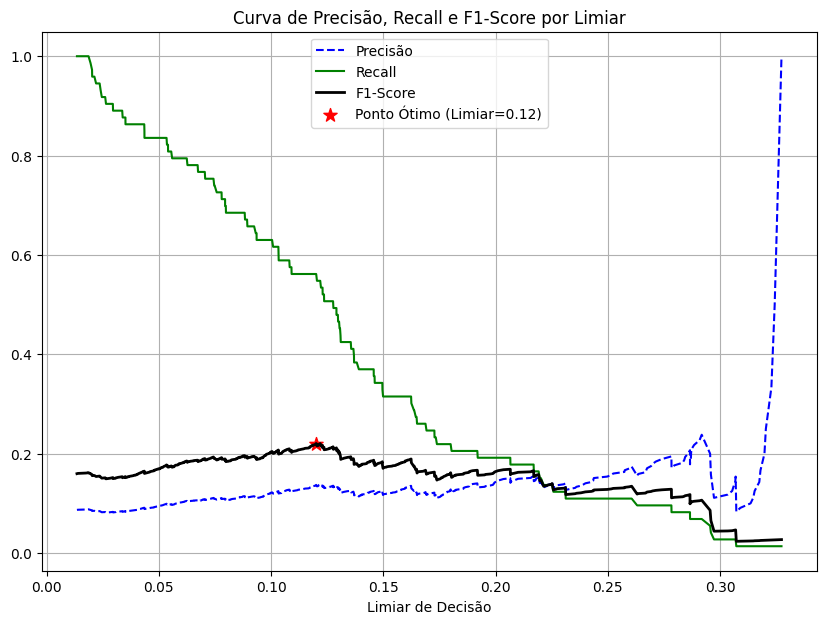


--- Re-avaliação com o Limiar Ótimo ---

--- Novo Relatório de Classificação ---
                    precision    recall  f1-score   support

  Classe 0 (Falha)       0.94      0.66      0.78       768
Classe 1 (Sucesso)       0.13      0.55      0.22        73

          accuracy                           0.65       841
         macro avg       0.54      0.61      0.50       841
      weighted avg       0.87      0.65      0.73       841


--- Nova Matriz de Confusão ---


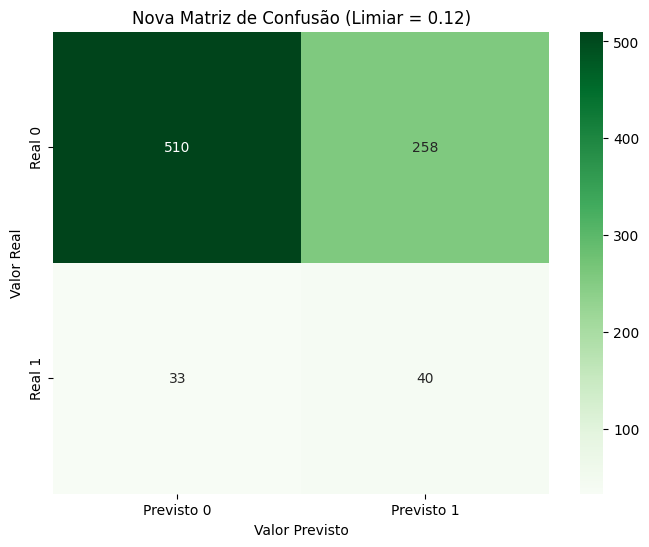

In [6]:
# CÉLULA 5: ENCONTRAR O LIMIAR DE DECISÃO ÓTIMO E RE-AVALIAR

from sklearn.metrics import precision_recall_curve, f1_score
from tensorflow.keras.models import load_model

# --- 1. Carregar o nosso PRIMEIRO e melhor modelo (o "cobarde") ---
print("A carregar o primeiro modelo ('oraculo_v2_best_model.h5')...")
model = load_model('oraculo_v2_best_model.h5')

# --- 2. Obter as probabilidades de previsão no conjunto de teste ---
# (Já fizemos isto na Célula 3, mas repetimos para clareza)
y_pred_proba = model.predict(X_test_seq)

# --- 3. Calcular a Curva de Precisão-Recall ---
# Esta curva mostra o trade-off entre precisão e recall para diferentes limiares.
precisions, recalls, thresholds = precision_recall_curve(y_test_seq, y_pred_proba)

# --- 4. Encontrar o Limiar que Maximiza o F1-Score ---
# O F1-Score é a média harmónica de precisão e recall. É uma ótima métrica para encontrar
# um bom equilíbrio entre os dois.
# Adicionamos um pequeno epsilon para evitar divisão por zero.
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-10)

# Localiza o índice do melhor F1-Score
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores[best_f1_idx]

print(f"\nLimiar de Decisão Ótimo encontrado: {best_threshold:.4f}")
print(f"  - Com este limiar, atingimos um F1-Score de: {best_f1_score:.4f}")


# --- 5. Visualizar a Curva e o Ponto Ótimo ---
plt.figure(figsize=(10, 7))
plt.plot(thresholds, precisions[:-1], "b--", label="Precisão")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "k-", label="F1-Score", linewidth=2)
plt.legend(loc="center left")
plt.xlabel("Limiar de Decisão")
plt.title("Curva de Precisão, Recall e F1-Score por Limiar")
plt.grid(True)
# Marca o ponto ótimo no gráfico
plt.scatter(best_threshold, best_f1_score, s=100, c='red', marker='*', label=f'Ponto Ótimo (Limiar={best_threshold:.2f})')
plt.legend()
plt.show()


# --- 6. RE-AVALIAR o modelo usando o NOVO LIMIAR ---
print("\n--- Re-avaliação com o Limiar Ótimo ---")
y_pred_optim = (y_pred_proba > best_threshold).astype(int)

print("\n--- Novo Relatório de Classificação ---")
print(classification_report(y_test_seq, y_pred_optim, target_names=['Classe 0 (Falha)', 'Classe 1 (Sucesso)']))

print("\n--- Nova Matriz de Confusão ---")
cm_optim = confusion_matrix(y_test_seq, y_pred_optim)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optim, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Previsto 0', 'Previsto 1'], 
            yticklabels=['Real 0', 'Real 1'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title(f'Nova Matriz de Confusão (Limiar = {best_threshold:.2f})')
plt.show()
